## Hyper-parameter optimization in concise

Hyper-parameter optimization comes quite handy in deep learning. There are different architectures to try out, different parameters, ... On the other hand, we only have a limited amount of time to inspect the results of each modeling choice and decide on the next set of hyper-parmaeters to try out.

By hyper-parameters I refer to any parameter that are not optimized by the learning algorithm (i.e. gradient descent). Some examples are: learning rate of gradient descent, batch size, number of hidden layers, whether to use skip-connections, particular way of pre-processing the data (say data augmentation amount), etc etc.

In genomics, being able to explore a vast amount of modeling choices automatically is important. Only a handful of papers (if any) have been written for your given task at hand, hence the space of different modeling choices has not been as extensively explored as for say image classification on [ImageNet](http://www.image-net.org/).

I will guide you through the typical process of hyper-parameter optimization, using the example from [PWM_initialization.ipynb](PWM_initialization.ipynb).

## Prerequisite

- please go throught the hyperopt wiki: https://github.com/hyperopt/hyperopt/wiki

## Steps in hyper-parameter optimization

1. Parametrize your preprocessing, model and training procedure
2. Define a range of values (and their distribution) for all the parameters
3. Run the optimization in a distributed fashion (on a cluster/multiple machines in parallel)
4. Inspect the results
  - Choose the best model
  - inspect the hyper-parameter <-> evaluation loss relation

## 1. Parametrize your preprocessing, model and training procedure

Hyper-parameter optimization in CONCISE assumes you have defined two functions: `data(...)` and `model(...)`.

### data() function

First, the define `data(...)`: a function returing the whole trainig, validation and test dataset.

- data() - returns a tuple: (train, test) or (train, valid, test), where:
  - train = (X_train, y_train, other1, other2, ...)
  - valid = (X_valid, y_valid)
  - test = (X_test, y_test)

- `X_*` is a numpy array, list of numpy arrays or a dictionary of numpy array
- `y_*` is the response variable

`X_train` and `y_train` are directly feed to the .fit method of a Keras model: `model.fit(x=X_train, y = y_train, ...)`

#### Example



In [1]:
from concise.preprocessing import encodeDNA
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
def data(seq_length=101):
      
    def load(split="train"):
        dt = pd.read_csv("../data/RBP/PUM2_{0}.csv".format(split))
        # DNA/RNA sequence
        xseq = encodeDNA(dt.seq, maxlen=seq_length, seq_align='center')
        # response variable
        y = dt.binding_site.as_matrix().reshape((-1, 1)).astype("float")
        if split=="train":
            from concise.data import attract
            # add also the pwm_list
            pwm_list = attract.get_pwm_list(["129"])
            return {"seq": xseq}, y, pwm_list
        else:
            return {"seq": xseq}, y

    return load("train"), load("valid"), load("test")

In [3]:
train, valid, test = data()

### model() function

`model()` returns a compiled Keras model. The only restriction on the parameters is that the function needs a `train_data` parameter. This allows you to extract the shape of your dataset.

In [101]:
import concise.layers as cl
import keras.layers as kl
import concise.initializers as ci
import concise.regularizers as cr
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.optimizers import Adam

def model(train_data, filters=1, kernel_size=9, motif_init=None, lr=0.001):
    seq_length = train_data[0]["seq"].shape[1]
    pwm_list = train_data[2]
    
    if motif_init is not None:
        # Motif init is a dictionary with fields: "stddev" 
        kinit = ci.PSSMKernelInitializer(pwm_list, 
                                         stddev=motif_init.get("stddev", 0.05),  # if not specified, use 0.05
                                         add_noise_before_Pwm2Pssm=True)
        binit = "zeros"
    else:
        kinit = "glorot_uniform"
        binit = "zeros"
        
        
    # sequence
    in_dna = cl.InputDNA(seq_length=seq_length, name="seq")
    x = cl.ConvDNA(filters=filters, 
                   kernel_size=kernel_size, 
                   activation="relu",
                   kernel_initializer=kinit,
                   bias_initializer=binit,
                   name="conv1")(in_dna)
    x = kl.AveragePooling1D(pool_size=4)(x)
    x = kl.Flatten()(x)
    
    x = kl.Dense(units=1)(x)
    m = Model(in_dna, x)
    m.compile(Adam(lr=lr), loss="binary_crossentropy", metrics=["acc"])
    return m

## 2. Define a search space for each hyper-parameter

Current hyper-parameters are the arguments of `data` and `model` functions:

- data:
  - seq_length
- model:
  - filters
  - kernel_size
  - motif_init (yes or no)
    - if yes: stddev
  - lr

Let's use a hyperopt pyll graph to define the hyper-parameter search space:

In [18]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

hyper_params = {
    "data": {
        "seq_length": hp.choice("d_seq_length", (101, 51, 21))
    },
    "model": {
        "filters": hp.choice("m_filters", (1, 16)),
        "kernel_size": 15,
        "motif_init": hp.choice("m_motif_init", (
                None,
                {"stddev": hp.uniform("m_stddev", 0, 0.2)}
            )),
        "lr": hp.loguniform("m_lr", np.log(1e-4), np.log(1e-2)) # 0.0001 - 0.01
        },
    "fit": {
        "epochs": 1,
        "patience": 5,
        "batch_size": 128,
    }
}

We are saying that
- `seq_length` in the data function should be 21, 51 or 101
- we should use 1 or 16 filter
- the learning rate should be from the range `[1e-4, 1e-2]`, sampled on a log-scale
- ...

Hyperopt also allows parameter nesting. This is demonstrated with the `["model"]["motif_init"]` parameter: we want to try a model with and without motif initialization...and if we decide on motif initialization, we want to explore different options for the "sttdev" parameter.

Read the `hyperopt` documentation about [defining the search space](https://github.com/hyperopt/hyperopt/wiki/FMin#2-defining-a-search-space) for more information.

Note that in addition to the `data()` and `model()` function arguments, we can also specify the hyper-parameters related to the training procedure (say batch_size or early-stopping patience).

## 3. Run the optimization

In [13]:
from concise.hyopt import CompileFN, CMongoTrials, test_fn

To run hyperopt, you need to define an objective function to minimize and the space of parameters you want to explore. Here is an example from the hyperopt tutorial:

In [16]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

logger = logging.getLogger()
logger.setLevel(logging.WARN)

def objective(x):
    return {'loss': x ** 2, 'status': STATUS_OK }

import logging
best = fmin(objective,
        space=hp.uniform('x', -10, 10),
        algo=tpe.suggest,
        max_evals=100)

print(best)

{'x': -0.0037076787079246554}


For supervised learning, the objective function is the evaluation metric on the validation dataset. Concise provides a class to compile the objective function given the data() and the model() function:

In [32]:
import hyopt_example # module with data.py and model.py
# We are using the data() and model() functions defined in a file
# The reason is that the serialization doens't work with functions
# defined in the notebook
objective = CompileFN(db_name="mydb", exp_name="motif_initialization",  # experiment name
                      data_fn=hyopt_example.data.data,
                      model_fn=hyopt_example.model.model, 
                      add_eval_metrics=["auprc", "auc"], # metrics from concise.eval_metrics, you can also use your own
                      loss_metric="auprc", # which metric to optimize for
                      loss_metric_mode="max", # maximum should be searched for
                      valid_split=None, # use valid from the data function
                      save_model='best', # checkpoint the best model
                      save_results=True, # save the results as .json (in addition to mongoDB)
                      save_dir="./saved_models/")  # place to store the models

Now, we can use hyper-opt do search the hyper-parameters:

### Test if everything works

Before starting many workers, its good to try running the objective function once. It's much easier to debug it that way.

In [31]:
# Test if the objective function works on a subset of data for one random hyper-parameter set
test_fn(objective, hyper_params)

['loss', 'acc']
Train on 1000 samples, validate on 4881 samples
Epoch 1/1
0s - loss: 3.3390 - acc: 0.7110 - val_loss: 3.0101 - val_acc: 0.7630
Returned value:
{'eval': {'acc': 0.76295840740203857,
          'auc': 0.52598029221882436,
          'auprc': 0.26792649640861294,
          'loss': 3.0101253986358643},
 'history': {'loss': {'acc': [0.71100000238418581],
                      'epoch': [0],
                      'loss': [3.3390192050933836],
                      'val_acc': [0.76295841021069832],
                      'val_loss': [3.0101239079458013]},
             'params': {'batch_size': 128,
                        'do_validation': True,
                        'epochs': 1,
                        'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
                        'samples': 1000,
                        'verbose': 2}},
 'loss': -0.26792649640861294,
 'name': {'data': 'data',
          'loss_metric': 'auprc',
          'loss_metric_mode': 'auprc',
          'model': '

### Run locally and sequentially

Trials() from hyperopt will run the jobs sequentially on a single machine

In [ ]:
cd hyopt_example

In [28]:
trials = Trials("hyopt_example")
best = fmin(objective,
            space=hyper_params,
            algo=tpe.suggest,
            trials=trials,
            max_evals=3)

['loss', 'acc']
Train on 17713 samples, validate on 4881 samples
Epoch 1/1
0s - loss: 0.6748 - acc: 0.7959 - val_loss: 0.5141 - val_acc: 0.7990
['loss', 'acc']
Train on 17713 samples, validate on 4881 samples
Epoch 1/1
0s - loss: 0.5069 - acc: 0.7957 - val_loss: 0.4666 - val_acc: 0.8007
['loss', 'acc']
Train on 17713 samples, validate on 4881 samples
Epoch 1/1
1s - loss: 0.5480 - acc: 0.7957 - val_loss: 0.4886 - val_acc: 0.7990


### Running the optimization in parallel on multiple workers

MongoTrials will defer the work to multiple workers running in parallel. All the results will get stored to the MongoDB database.

In [30]:
# just replaced Trials with CMongoTrials
trials = CMongoTrials(db_name="hyopt_example", exp_name="motif_initialization")
best = fmin(objective,
            space=hyper_params,
            algo=tpe.suggest,
            trials=trials,
            max_evals=300)

2017-08-16 14:59:26,520 [WARNING] over-writing old domain trials attachment


This script waits for workers to complete the work. Start the workers by running the following bash script many times in parallel:

```bash
#!/bin/bash
#
# Slurm parameters
#SBATCH --mem=16G
#SBATCH -c 4
# ------------------

DB=hyopt_example
# path to the repository containing the script
export PYTHONPATH="."

hyperopt-mongo-worker \
    --mongo=ouga03:1234/$DB \
    --poll-interval=1 \
    --reserve-timeout=3600 \
    --workdir="."
```

### Running the workers on SLURM

Run: 
```bash
$ for i in {1..20}; do sbatch start_worker.bash; done
```

## Sidenote: Code organization

I typically organize the code in the following files:

- data.py
  - contains data() function
- model.py
  - contains model() function
- train.py
  - Defines the hyper_parameter ranges
  - Runs hyperopt.fmin()  
  
See the `nbs/hyopt_example` folder.

## 4. Inspect the results

Hyperopt keeps track of all the trials (parameters + resulting objective loss) in a Monogo database. The object `hyperopt.MongoTrials` provides a handle to the databse. Concise extends the class `hyperopt.MongoTrials` with some additional methods for easier hyper-parameter inspection.

Since the results are stored in a database, you only need to know the database and the experiment name in order to access the database from any folder:

In [173]:
trials = CMongoTrials(db_name="hyopt_example", exp_name="motif_initialization", ip="ouga03")

2017-08-16 11:54:49,098 [INFO] PROTOCOL mongo
2017-08-16 11:54:49,098 [INFO] USERNAME None
2017-08-16 11:54:49,099 [INFO] HOSTNAME ouga03
2017-08-16 11:54:49,100 [INFO] PORT 1234
2017-08-16 11:54:49,101 [INFO] PATH /hyopt_example/jobs
2017-08-16 11:54:49,101 [INFO] DB hyopt_example
2017-08-16 11:54:49,102 [INFO] COLLECTION jobs
2017-08-16 11:54:49,103 [INFO] PASS None


In [174]:
# Number of completed trials
len(trials)

300

### Tidy table of hyperparameters

In [175]:
df = trials.as_df().sort_values("eval.auprc")
df.sort_values("eval.auprc", ascending=False).head()

,tid,loss,status,eval.acc,eval.auc,eval.auprc,eval.loss,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.seq_length,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.model.filters,param.model.kernel_size,param.model.lr,param.model.motif_init,param.model.motif_init.stddev,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start,n_epoch
257,277,-0.7221,ok,0.8701,0.8693,0.7221,0.3543,data,auprc,auprc,model,101,128,val_loss,50,5,16,15,0.0054,NaN,0.0252,./saved_models/hyopt_...,./saved_models/hyopt_...,23.1172,52.1519,29.0347,2017-08-16 11:52:06.8...,2017-08-16 11:51:14.6...,14
137,157,-0.7218,ok,0.8689,0.8725,0.7218,0.3417,data,auprc,auprc,model,101,128,val_loss,50,5,16,15,0.0050,NaN,0.0102,./saved_models/hyopt_...,./saved_models/hyopt_...,28.3887,93.0859,64.6972,2017-08-16 11:46:30.3...,2017-08-16 11:44:57.2...,34
275,295,-0.7191,ok,0.8697,0.8708,0.7191,0.3504,data,auprc,auprc,model,101,128,val_loss,50,5,16,15,0.0055,NaN,0.0253,./saved_models/hyopt_...,./saved_models/hyopt_...,28.5676,66.6112,38.0437,2017-08-16 11:53:20.5...,2017-08-16 11:52:13.9...,21
294,314,-0.7188,ok,0.8728,0.8660,0.7188,0.3597,data,auprc,auprc,model,101,128,val_loss,50,5,16,15,0.0090,NaN,0.0363,./saved_models/hyopt_...,./saved_models/hyopt_...,28.3512,50.3183,21.9670,2017-08-16 11:54:08.6...,2017-08-16 11:53:18.3...,10
270,290,-0.7148,ok,0.8687,0.8686,0.7148,0.3518,data,auprc,auprc,model,101,128,val_loss,50,5,16,15,0.0067,NaN,0.0463,./saved_models/hyopt_...,./saved_models/hyopt_...,23.6120,58.8660,35.2540,2017-08-16 11:53:04.3...,2017-08-16 11:52:05.4...,17


We can see that the best trial achieved auPRC=0.72 on the validation set.

### Was the number of evaulated trials enough?

In [176]:
best_loss = np.maximum.accumulate(df.sort_values("tid")["eval.auprc"])

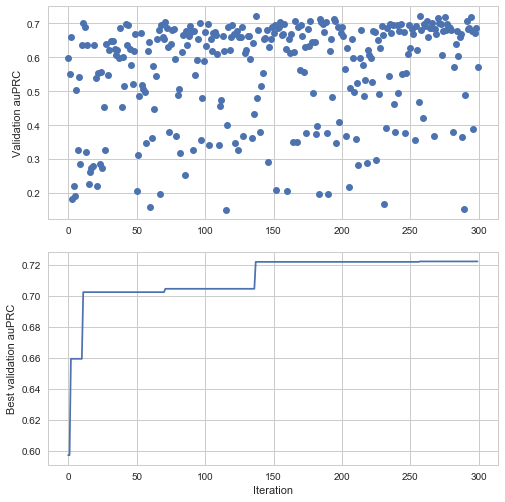

In [178]:
fig, ax = plt.subplots(nrows=2, figsize=(7,7))
fig.tight_layout()
ax[0].plot(df.sort_values("tid")["eval.auprc"], linestyle="", marker="o")
ax[0].set(ylabel="Validation auPRC")
ax[1].plot(best_loss)
ax[1].set(xlabel="Iteration",ylabel="Best validation auPRC");

We can see that through time, hyperopt finds more and more good hyper-parameter configurations.

### Load best model, evaluate it on the test set

In [181]:
cd hyopt_example

/data/nasif12/home_if12/avsec/projects-work/concise/nbs/hyopt_example


In [186]:
best_tid = trials.best_trial_tid()
params = trials.get_param(best_tid).to_dict()
model = trials.load_model(best_tid)

In [188]:
# Best hyper-parameters were:
params

{'data': {'seq_length': 101},
 'fit': {'batch_size': 128,
  'early_stop_monitor': 'val_loss',
  'epochs': 50,
  'patience': 5},
 'model': {'filters': 16,
  'kernel_size': 15,
  'lr': 0.005370016473899783,
  'motif_init': {'stddev': 0.02517910263989817}}}

In [189]:
import data

In [191]:
# Load the train, valid, test
train, valid, test = data.data(**params["data"])

In [192]:
y_pred_test = model.predict(test[0])

In [193]:
import concise.eval_metrics as cem

In [200]:
# Performance on the test-set:
cem.auprc(test[1], y_pred_test)

0.73280952522362308

### Training curve of the best model

In [250]:
train_hist = trials.train_history(best_tid)

In [251]:
train_hist.head()

,tid,epoch,acc,loss,val_acc,val_loss
0,277,0,0.8209,0.4828,0.8408,0.3954
1,277,1,0.8466,0.4031,0.8506,0.3867
2,277,2,0.8574,0.3788,0.8556,0.3778
3,277,3,0.8647,0.3633,0.8621,0.3552
4,277,4,0.8682,0.3521,0.8664,0.3770


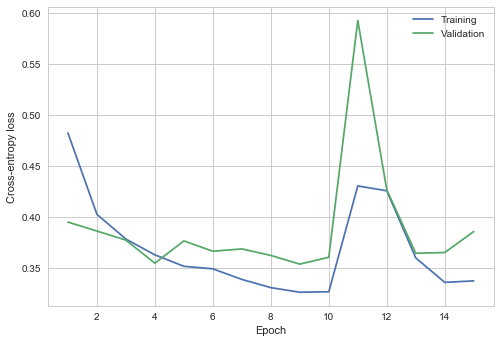

In [261]:
plt.plot(train_hist.epoch + 1, train_hist.loss, label="Training")
plt.plot(train_hist.epoch + 1, train_hist.val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

We can see that the optimal number of epochs is 10.

### Which hyper-parameters are better than others?

To draw conclusions and guide future design, its useful to inspect which hyper-parameters lead to good results. Typically, this means to plot the loss function against the hyper-parameter we are interested in. Since we already have a tidy table with the hyper-parameter experiment results, this is pretty straighforward.

#### Learning rate

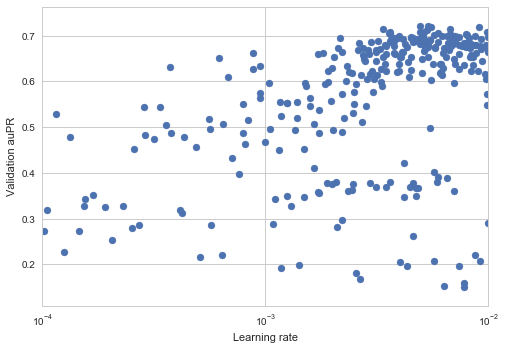

In [218]:
plt.scatter(df["param.model.lr"], df["eval.auprc"])
plt.xlim([1e-4, 1e-2])
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Validation auPR");

#### Motif initialization

In [219]:
import seaborn as sns

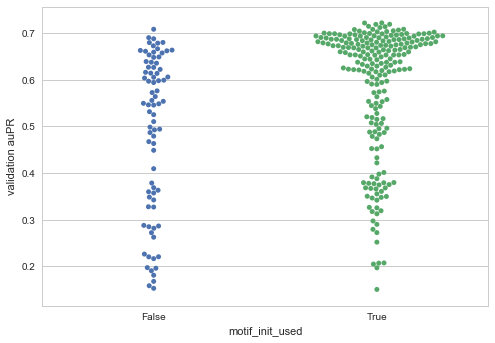

In [267]:
df["motif_init_used"] = ~df["param.model.motif_init.stddev"].isnull()
sns.swarmplot("motif_init_used", "eval.auprc", data=df)
plt.ylabel("validation auPR");

Motif initialization helped to achieve better performance. We can also see that the hyper-parameter optimization algorithm has drawn more samples using it, since it figured out it yields better performance.

##### Additional variance on the motif initialization

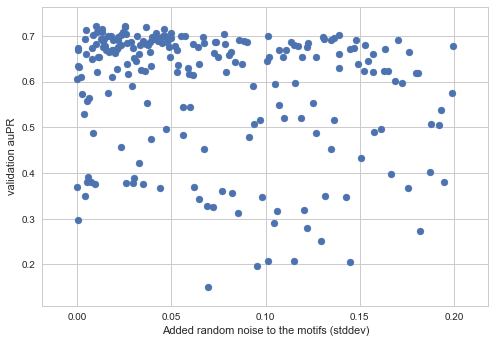

In [245]:
plt.scatter(df["param.model.motif_init.stddev"], df["eval.auprc"])
plt.ylabel("validation auPR");
plt.xlabel("Added random noise to the motifs (stddev)");

#### Number of filters

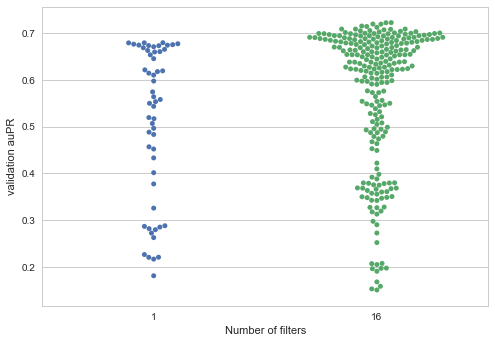

In [247]:
sns.swarmplot("param.model.filters", "eval.auprc", data=df)
plt.ylabel("validation auPR")
plt.xlabel("Number of filters");

#### Sequence length

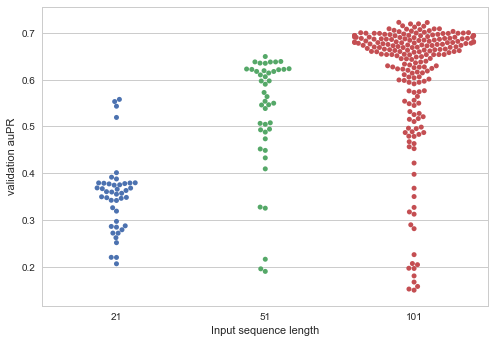

In [249]:
sns.swarmplot("param.data.seq_length", "eval.auprc", data=df)
plt.ylabel("validation auPR")
plt.xlabel("Input sequence length");